In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
import os
from collections import defaultdict
import math
from scipy.stats import pearsonr
import numpy as np
#import matplotlib.pyplot as plt

In [12]:
# directory containing the decifer output
#base_dir = "/Users/bjarnold/Princeton_DataX/decifer/test/data"
base_dir = "/Users/bjarnold/Princeton_DataX/decifer/test"

min_snps = 0 # minimum SNPs per cluster; use this number to filter out clusters with few SNPs

# read primary decifer output
df = pd.read_csv("{}/decifer.output.tsv".format(base_dir), sep='\t', lineterminator='\n')

# This is a dictionary mapping sample indices in decifer to their actual name; for instance, the 'sample index' and 'sample_label' columns of *.cluster.CIs.tsv
sample_ids = {"0":"D", "1":"C", "2":"A"}

# get number of samples, which may vary between patients. Each sample has a VAR_# column
num_samples = sum([1 if "VAR" in i else 0 for i in df.columns])




In [13]:
# filter out clusters with few SNPs
print("SNPs per cluster")
cluster_counts = df['cluster'].value_counts() # returns a series
print(cluster_counts)
large_clusters = [i if cluster_counts[i] >= min_snps else None for i in cluster_counts.index ] # access .value_counts() series with .index
df = df.loc[df['cluster'].isin(large_clusters)]

df['TOT'] = df[['TOT_{}'.format(i) for i in range(num_samples)]].sum(axis=1)


SNPs per cluster
1    125
6     20
2     10
5      4
Name: cluster, dtype: int64


6 true_cluster_DCF0    0.0020102043398742804;(0.0001,0.0156)
true_cluster_DCF1       0.5616821060749985;(0.4811,0.6494)
true_cluster_DCF2       0.8319378058112255;(0.7925,0.8322)
Name: 153, dtype: object
1 true_cluster_DCF0    1.0;(0.9891,0.9999)
true_cluster_DCF1    1.0;(0.9855,0.9998)
true_cluster_DCF2    1.0;(0.9859,0.9999)
Name: 158, dtype: object
2 true_cluster_DCF0    0.9325059157912502;(0.8034,0.9993)
true_cluster_DCF1                      0.0;(0.0,0.0239)
true_cluster_DCF2                      0.0;(0.0,0.0256)
Name: 107, dtype: object
5 true_cluster_DCF0     0.5202993981469003;(0.3673,0.7063)
true_cluster_DCF1    0.46699907331053986;(0.3226,0.6476)
true_cluster_DCF2     0.4128782652780715;(0.2753,0.5902)
Name: 119, dtype: object
159
159


/Users/bjarnold/miniconda/envs/datascience/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


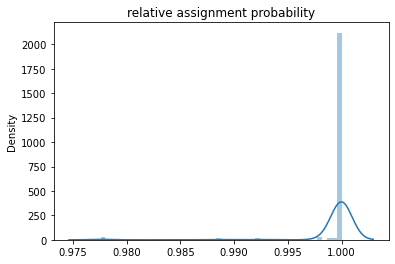

In [14]:
# filter out SNVs with lower probability of cluster assignment
prob_assignment_threshold = 0.5
probs = defaultdict(list)
cluster_centers = defaultdict(list)
for index, row in df.iterrows():
        # calculate probabilities
        x = [float(i) for i in row['LHs'].split(";")]
        x.sort()
        num = math.exp(-x[0])
        denom = sum([math.exp(-x[0]) + math.exp(-x[1])])
        probs["prob_assign"].append(num/denom)
        
        # get cluster centers
        cluster_centers[row['cluster']] = row[['true_cluster_DCF{}'.format(i) for i in range(num_samples)]]


for i in cluster_centers:
    print(i, cluster_centers[i])
sns.distplot(probs["prob_assign"]).set_title('relative assignment probability')

df = pd.concat([df, pd.DataFrame.from_dict(probs)], axis=1)
print(len(df))
df = df[df.prob_assign > prob_assignment_threshold]
print(len(df))
#print "column names:"
#print df.columns

/Users/bjarnold/miniconda/envs/datascience/lib/python3.8/site-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/bjarnold/miniconda/envs/datascience/lib/python3.8/site-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


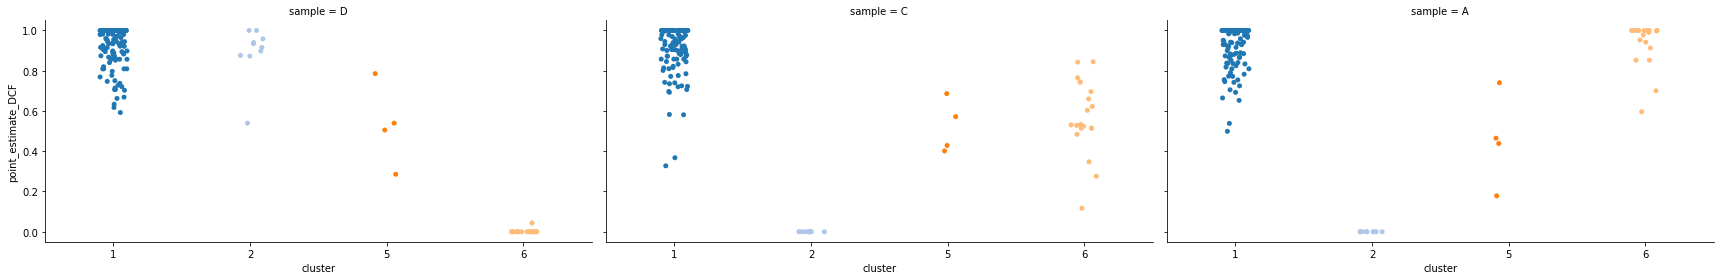

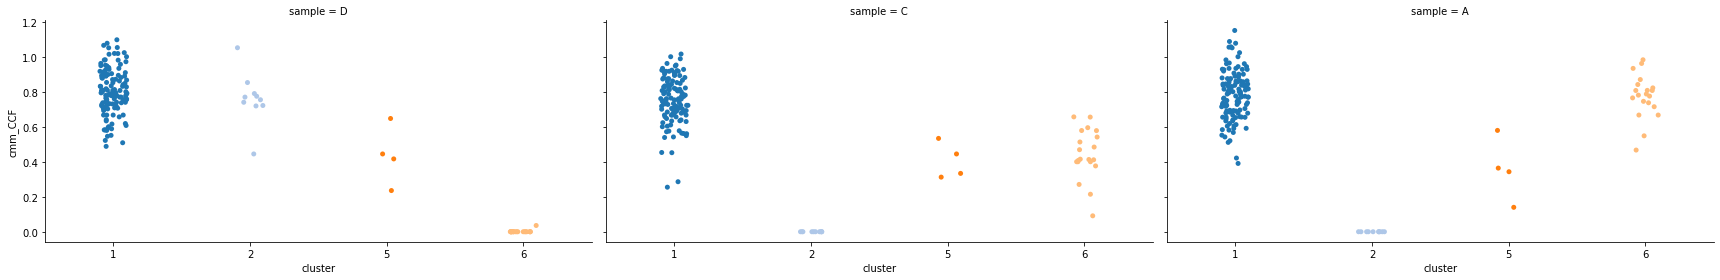

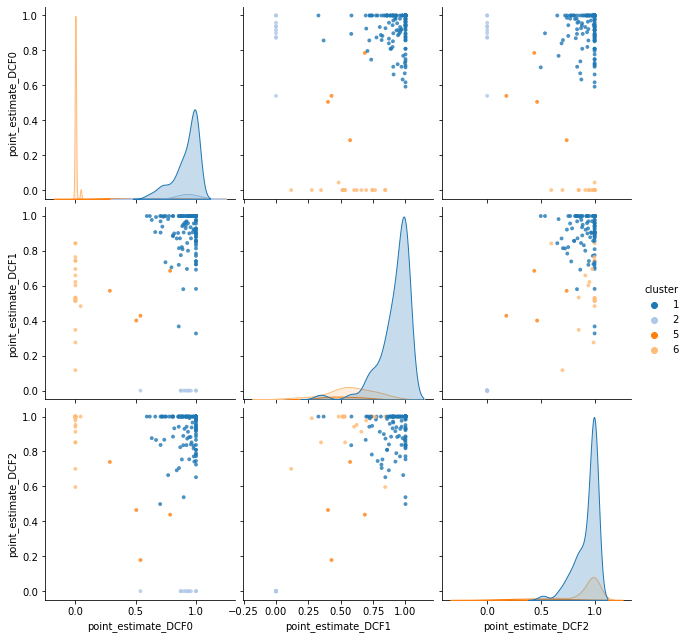

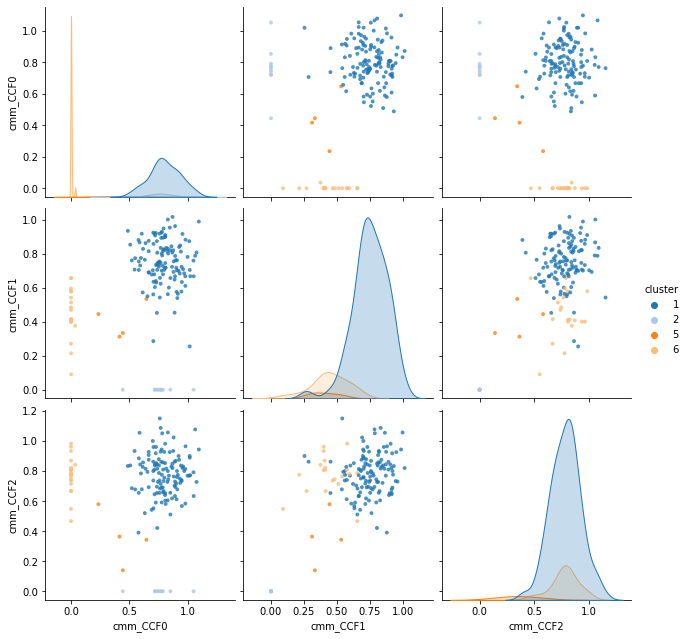

In [15]:
# look at DCF values
cols = ["mut_index", "cluster"]
cols.extend(['point_estimate_DCF{}'.format(i) for i in range(num_samples)])
df_dcf = df[cols]
#print df_dcf.head(5)

df_dcf_wide = pd.melt(df_dcf, 
                      id_vars=["mut_index", "cluster"], # columns you don't want to convert 
                      value_vars = ["point_estimate_DCF{}".format(i) for i in range(num_samples)], #columns to convert wide -> long
                      var_name = "sample", #rename 
                      value_name = "point_estimate_DCF")  #rename
# rename samples by index, i.e. remove point_estimate_DCF, and replacing indices with actual names
df_dcf_wide["sample"] = df_dcf_wide["sample"].str.replace('point_estimate_DCF', '', regex=False)
df_dcf_wide["sample"] = df_dcf_wide["sample"].map(sample_ids)
#print df_dcf_wide.head(5)


cols = ["mut_index", "cluster"]
cols.extend(['cmm_CCF{}'.format(i) for i in range(num_samples)])
df_ccf = df[cols]
#print df_dcf.head(5)

df_ccf_wide = pd.melt(df_ccf, 
                      id_vars=["mut_index", "cluster"], # columns you don't want to convert 
                      value_vars = ["cmm_CCF{}".format(i) for i in range(num_samples)], #columns to convert wide -> long
                      var_name = "sample", #rename 
                      value_name = "cmm_CCF")  #rename
# rename samples by index, i.e. remove point_estimate_DCF, and replacing indices with actual names
df_ccf_wide["sample"] = df_ccf_wide["sample"].str.replace('cmm_CCF', '', regex=False)
df_ccf_wide["sample"] = df_ccf_wide["sample"].map(sample_ids)
#print df_dcf_wide.head(5)


sns.catplot(x="cluster", y="point_estimate_DCF",
            hue="cluster", col="sample",
            data=df_dcf_wide, kind="strip",
            height=4, aspect=2,
           palette="tab20")

sns.catplot(x="cluster", y="cmm_CCF",
            hue="cluster", col="sample",
            data=df_ccf_wide, kind="strip",
            height=4, aspect=2,
           palette="tab20")

sns.pairplot(df_dcf,
             vars=["point_estimate_DCF{}".format(i) for i in range(num_samples)],
             hue='cluster', 
             palette="tab20",
             plot_kws={'alpha': 0.8, 's':15, 'edgecolor':"none"},
             size=3,
            diag_kind="kde")

sns.pairplot(df_ccf,
             vars=["cmm_CCF{}".format(i) for i in range(num_samples)],
             hue='cluster', 
             palette="tab20",
             plot_kws={'alpha': 0.8, 's':15, 'edgecolor':"none"},
             size=3,
            diag_kind="kde")